<a href="https://colab.research.google.com/github/alinjomaa/Mask-RCNN_D2_PointRend_C.Elegan_segmentation/blob/main/finetuned_sam3_C_elegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-Tuned SAM 3 Model for Worm Segmentation via Point Prompts

In this notebook, I fine-tuned Meta's SAM 3 model on a custom dataset of *C. elegans* worms. When comparing inference results between the Detectron2 Mask R-CNN model and SAM 3, I found that SAM 3 achieved significantly greater accuracy in segmenting touching and overlapping worms. The primary limitation of using SAM 3 is its requirement for prompting.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install dependencies
!pip install torch==2.7.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

# Clone and install SAM3
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e .

# Install Hugging Face hub for model download
!pip install huggingface_hub

Looking in indexes: https://download.pytorch.org/whl/cu126
fatal: destination path 'sam3' already exists and is not an empty directory.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15369 sha256=4ad297f2edec7ec74581c94640cb51bb80c37fba7e12840e85516f98b7c6215a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ggiia6w6/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0


In [ ]:
from huggingface_hub import login
login()

In [ ]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 114.3 MB/s eta 0:00:00


In [ ]:
import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, ConcatDataset
from pycocotools import mask as mask_utils


class WormDataset(Dataset):
    def __init__(self, coco_json_path, image_dir):
        with open(coco_json_path, "r") as f:
            coco_data = json.load(f)

        self.image_dir = image_dir
        self.images = coco_data["images"]
        self.annotations = coco_data["annotations"]

        self.img_to_anns = {}
        for ann in self.annotations:
            img_id = ann["image_id"]
            if img_id not in self.img_to_anns:
                self.img_to_anns[img_id] = []
            self.img_to_anns[img_id].append(ann)

    def __len__(self):
        return len(self.images)

    def _ann_to_mask(self, ann, height, width):
        seg = ann.get("segmentation", None)
        if seg is None:
            return None

        if isinstance(seg, list):
            if len(seg) > 0 and isinstance(seg[0], (int, float)):
                seg = [seg]

            rles = mask_utils.frPyObjects(seg, height, width)


            if isinstance(rles, dict):
                rle = rles
            else:
                rle = mask_utils.merge(rles)

            mask = mask_utils.decode(rle)
            return mask


        if isinstance(seg, dict):
            rle = seg


            if isinstance(rle.get("counts", None), list):
                rle = mask_utils.frPyObjects(rle, height, width)

            mask = mask_utils.decode(rle)
            return mask

        return None

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.image_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")

        height = img_info.get("height", image.height)
        width = img_info.get("width", image.width)

        anns = self.img_to_anns.get(img_info["id"], [])

        masks = []
        points = []

        for ann in anns:
            mask = self._ann_to_mask(ann, height, width)
            if mask is None:
                continue


            if mask.ndim == 3:
                mask = mask[:, :, 0]

            if mask.sum() == 0:
                continue

            masks.append(mask.astype(np.uint8))

            ys, xs = np.where(mask > 0)
            cx = int(xs.mean())
            cy = int(ys.mean())
            points.append([cx, cy])

        if len(masks) == 0:
            masks = np.zeros((1, height, width), dtype=np.uint8)
            points = []

        masks = torch.from_numpy(np.stack(masks)).float()

        if len(points) == 0:
            points = torch.zeros((0, 2), dtype=torch.float32)
        else:
            points = torch.tensor(points, dtype=torch.float32)

        return {
            "image": image,
            "masks": masks,
            "points": points
        }


dataset1 = WormDataset(
    "/content/drive/MyDrive/worm_segmentation/annotations_cleaned.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train"
)

dataset2 = WormDataset(
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/annotations/annotations.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/images"
)

dataset3 = WormDataset(
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2_annotations/_annotations.coco.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2"
)

train_dataset = ConcatDataset([dataset1, dataset2, dataset3])

print("Total training images:", len(train_dataset))
print("  - Dataset 1:", len(dataset1), "images")
print("  - Dataset 2:", len(dataset2), "images")
print("  - Dataset 3:", len(dataset3), "images")



Total training images: 1626
  - Dataset 1: 197 images
  - Dataset 2: 1000 images
  - Dataset 3: 429 images


In [ ]:
import os
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import Sam3TrackerModel, Sam3TrackerProcessor


def custom_collate(batch):
    return {
        "image": [item["image"] for item in batch],
        "masks": [item["masks"] for item in batch],
        "points": [item["points"] for item in batch],
    }


def dice_loss_with_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    probs = probs.reshape(probs.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)
    inter = (probs * targets).sum(dim=1)
    denom = probs.sum(dim=1) + targets.sum(dim=1)
    dice = (2 * inter + eps) / (denom + eps)
    return (1 - dice).mean()


def mean_iou_from_logits(logits, targets, thr=0.5, eps=1e-6):
    preds = (torch.sigmoid(logits) > thr).float()
    preds = preds.reshape(preds.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)
    inter = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()


def choose_one_instance(masks, points):
    if masks.ndim == 2:
        masks = masks.unsqueeze(0)

    n = masks.shape[0]
    if n == 0:
        return None, None

    k = random.randint(0, n - 1)

    if torch.is_tensor(points) and points.ndim == 2 and points.shape[0] == n:
        return masks[k].unsqueeze(0), points[k].unsqueeze(0)

    return masks[k].unsqueeze(0), None


def point_from_single_mask(single_mask):
    if single_mask.ndim == 3:
        m = single_mask[0]
    else:
        m = single_mask

    ys, xs = torch.where(m > 0.5)
    if ys.numel() > 0:
        y = int(torch.mean(ys.float()).item())
        x = int(torch.mean(xs.float()).item())
        return torch.tensor([[x, y]], dtype=torch.float32)

    h = m.shape[-2]
    w = m.shape[-1]
    return torch.tensor([[w // 2, h // 2]], dtype=torch.float32)


def get_pred_logits(outputs):
    pred = outputs.pred_masks

    # Remove singleton dimensions more carefully
    while pred.ndim > 3:
        if pred.shape[0] == 1:
            pred = pred.squeeze(0)
        else:
            pred = pred[0]
            break

    if pred.ndim == 3:
        pred = pred[0].unsqueeze(0)

    if pred.ndim == 2:
        pred = pred.unsqueeze(0)

    return pred


def align_gt_to_pred(pred_logits, gt_mask):
    if gt_mask.ndim == 2:
        gt_mask = gt_mask.unsqueeze(0)
    gt_mask = gt_mask.float()

    if pred_logits.shape[-2:] != gt_mask.shape[-2:]:
        gt_mask = F.interpolate(
            gt_mask.unsqueeze(1),
            size=pred_logits.shape[-2:],
            mode="bilinear",
            align_corners=False
        ).squeeze(1)

    if pred_logits.shape != gt_mask.shape:
        raise ValueError("Shape mismatch pred " + str(tuple(pred_logits.shape)) + " vs gt " + str(tuple(gt_mask.shape)))

    return gt_mask


def train_sam3(
    train_dataset,
    num_epochs=20,
    batch_size=1,
    lr=1e-4,
    weight_decay=0.01,
    grad_accum=4,
    use_amp=True,
    save_dir="/content/drive/MyDrive/sam3_worm_checkpoints",
    save_every_steps=500
):
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_cuda = (device.type == "cuda")

    model = Sam3TrackerModel.from_pretrained("facebook/sam3")
    processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

    for name, p in model.named_parameters():
        if "vision_encoder" in name or "image_encoder" in name:
            p.requires_grad = False
        else:
            p.requires_grad = True

    trainable = [p for p in model.parameters() if p.requires_grad]
    if len(trainable) == 0:
        for p in model.parameters():
            p.requires_grad = True
        trainable = list(model.parameters())

    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(trainable, lr=lr, weight_decay=weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and use_cuda))

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=custom_collate
    )

    global_step = 0
    accum_steps = 0

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_iou = 0.0

        seen = 0
        success = 0
        auto_points = 0
        failed = 0
        skipped = 0

        optimizer.zero_grad(set_to_none=True)

        pbar = tqdm(train_loader, desc="Epoch " + str(epoch + 1) + "/" + str(num_epochs))

        for batch in pbar:
            for bi in range(len(batch["image"])):
                seen += 1

                image = batch["image"][bi]
                masks = batch["masks"][bi].to(device)
                points = batch["points"][bi]

                try:
                    gt_mask, pt = choose_one_instance(masks, points)
                    if gt_mask is None:
                        skipped += 1
                        continue

                    if pt is None or (torch.is_tensor(pt) and pt.numel() == 0):
                        pt = point_from_single_mask(gt_mask.detach())
                        auto_points += 1

                    if not torch.is_tensor(pt):
                        pt = torch.tensor(pt, dtype=torch.float32)

                    input_points = [[pt.detach().cpu().tolist()]]
                    input_labels = [[[1] * pt.shape[0]]]

                    inputs = processor(
                        images=image,
                        input_points=input_points,
                        input_labels=input_labels,
                        return_tensors="pt"
                    )
                    inputs = inputs.to(device)

                    if use_amp and use_cuda:
                        with torch.cuda.amp.autocast():
                            outputs = model(**inputs, multimask_output=False)
                            pred_logits = get_pred_logits(outputs)
                            gt_aligned = align_gt_to_pred(pred_logits, gt_mask)
                            loss = F.binary_cross_entropy_with_logits(pred_logits, gt_aligned) + dice_loss_with_logits(pred_logits, gt_aligned)
                            loss = loss / grad_accum
                    else:
                        outputs = model(**inputs, multimask_output=False)
                        pred_logits = get_pred_logits(outputs)
                        gt_aligned = align_gt_to_pred(pred_logits, gt_mask)
                        loss = F.binary_cross_entropy_with_logits(pred_logits, gt_aligned) + dice_loss_with_logits(pred_logits, gt_aligned)
                        loss = loss / grad_accum

                    if scaler.is_enabled():
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()

                    accum_steps += 1


                    if accum_steps >= grad_accum:
                        if scaler.is_enabled():
                            scaler.unscale_(optimizer)

                        torch.nn.utils.clip_grad_norm_(trainable, 1.0)

                        if scaler.is_enabled():
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            optimizer.step()

                        optimizer.zero_grad(set_to_none=True)
                        accum_steps = 0

                    success += 1
                    global_step += 1

                    epoch_loss += loss.item() * grad_accum
                    epoch_iou += mean_iou_from_logits(pred_logits.detach(), gt_aligned.detach())

                    avg_loss = epoch_loss / max(1, success)
                    avg_iou = epoch_iou / max(1, success)

                    pbar.set_postfix({
                        "Loss": f"{(loss.item() * grad_accum):.4f}",
                        "Avg": f"{avg_loss:.4f}",
                        "IoU": f"{avg_iou:.3f}",
                        "Success": str(success) + "/" + str(seen),
                        "AutoPts": auto_points,
                        "Skip": skipped,
                        "Fail": failed
                    })

                    if save_every_steps and global_step % save_every_steps == 0:
                        ckpt_path = os.path.join(save_dir, "step_" + str(global_step))
                        os.makedirs(ckpt_path, exist_ok=True)
                        model.save_pretrained(ckpt_path)

                except Exception as e:
                    failed += 1
                    if failed <= 5:
                        print("\nFAILED example:", str(e))
                        try:
                            print("masks shape:", tuple(masks.shape))
                        except:
                            pass
                    continue


        if accum_steps > 0:
            if scaler.is_enabled():
                scaler.unscale_(optimizer)

            torch.nn.utils.clip_grad_norm_(trainable, 1.0)

            if scaler.is_enabled():
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()

            optimizer.zero_grad(set_to_none=True)
            accum_steps = 0

        print("\nEpoch", epoch + 1, "done")
        print("Avg loss:", epoch_loss / max(1, success))
        print("Avg IoU :", epoch_iou / max(1, success))
        print("Success:", str(success) + "/" + str(seen))
        print("Auto points:", auto_points, "| Skipped:", skipped, "| Failed:", failed)


train_sam3(train_dataset, num_epochs=20, batch_size=1, grad_accum=4, use_amp=True)

In [ ]:
import base64
from io import BytesIO
from PIL import Image

OBJECTS = ['worm']

def encode_image_pillow(image: Image.Image) -> str:
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    image_bytes = buffer.getvalue()
    encoded = base64.b64encode(image_bytes).decode("utf-8")
    return "data:image/jpeg;base64," + encoded

In [ ]:
import numpy as np

def get_normalized_boxes(bboxes, label, resolution_wh):
    width, height = resolution_wh
    boxes = [
        [b["x"] + b["width"] / 2, b["y"] + b["height"] / 2, b["width"], b["height"]]
        for b in bboxes
        if b["label"] == label
    ]
    if not boxes:
        return np.empty((0, 4), dtype=np.float32)
    scale = np.array([width, height, width, height], dtype=np.float32).reshape(1,-1)
    return np.array(boxes, dtype=np.float32) / scale

In [ ]:
!pip install jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.8 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from jupyter_bbox_widget import BBoxWidget


image_path = "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/test/5 10 50 mM smells fed and sDR.lif_5mM 2B sDR_ch02.jpg"
image = Image.open(image_path).convert("RGB")

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image_pillow(image)
widget

Loading weights:   0%|          | 0/685 [00:00<?, ?it/s]

Derived 25 points from bounding boxes. Performing inference...


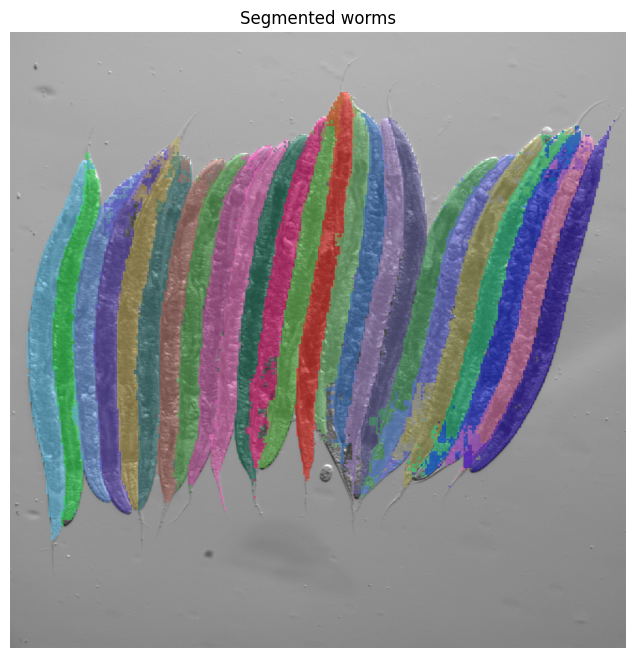

Successfully segmented 25 objects.
Saved masks to: /content/worm_segmentation_masks.npy with shape (25, 1024, 1024)


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import Sam3TrackerModel, Sam3TrackerProcessor
import shutil
import os
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

model_save_dir = "/content/drive/MyDrive/sam3_worm_checkpoints"
model_checkpoint_name = "step_22500"

model_path_on_drive = os.path.join(model_save_dir, model_checkpoint_name)
local_model_path = os.path.join("/content", model_checkpoint_name)

if not os.path.exists(local_model_path):
    print(f"Copying model from drive: {model_path_on_drive} to {local_model_path}")
    try:
        shutil.copytree(model_path_on_drive, local_model_path)
        print("Model copied successfully.")
    except Exception as e:
        print(f"Error copying model: {e}")
        print("Please ensure the model path exists and is accessible.")
        raise

needed_files = ["config.json", "model.safetensors"]
missing_files = []
for filename in needed_files:
    full_path = os.path.join(local_model_path, filename)
    if not os.path.exists(full_path):
        missing_files.append(filename)

if missing_files:
    raise FileNotFoundError(f"Missing in {local_model_path}: {missing_files}")

model = Sam3TrackerModel.from_pretrained(local_model_path).to(device)
model.eval()

try:
    processor = Sam3TrackerProcessor.from_pretrained(local_model_path)
except Exception:
    processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

bbox_annotations = widget.bboxes

input_points_for_processor = []
input_labels_for_processor = []

if bbox_annotations:
    current_image_points = []
    current_image_labels = []

    for bbox_info in bbox_annotations:
        x_min = bbox_info["x"]
        y_min = bbox_info["y"]
        width = bbox_info["width"]
        height = bbox_info["height"]

        center_x = x_min + (width / 2)
        center_y = y_min + (height / 2)

        current_image_points.append([[center_x, center_y]])
        current_image_labels.append([1])

    input_points_for_processor.append(current_image_points)
    input_labels_for_processor.append(current_image_labels)

if (not input_points_for_processor) or (len(input_points_for_processor[0]) == 0):
    print("No points derived from bounding boxes for segmentation.")
else:
    num_derived_points = len(input_points_for_processor[0])
    print(f"Derived {num_derived_points} points from bounding boxes. Performing inference...")

    overlay = np.array(image).astype(np.float32)
    all_masks = []

    inputs = processor(
        images=image,
        input_points=input_points_for_processor,
        input_labels=input_labels_for_processor,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    pred_masks = outputs.pred_masks

    if pred_masks.ndim == 5:
        pred_masks = pred_masks[:, :, 0, :, :]

    if pred_masks.ndim != 4:
        raise ValueError(f"Unexpected pred_masks shape: {tuple(outputs.pred_masks.shape)}")

    num_objects = pred_masks.shape[1]

    for i in range(num_objects):
        mask_logit = pred_masks[0, i, :, :]

        mask = (torch.sigmoid(mask_logit) > 0.3).cpu().numpy().astype(np.uint8)

        mask_pil = Image.fromarray(mask)
        mask_resized = mask_pil.resize((image.width, image.height), Image.NEAREST)
        mask = np.array(mask_resized)

        all_masks.append(mask)

        color = np.random.uniform(0, 255, size=(3,))
        alpha = 0.5

        overlay[mask == 1] = overlay[mask == 1] * (1 - alpha) + color * alpha

    plt.figure(figsize=(10, 8))
    plt.imshow(overlay.astype(np.uint8))
    plt.axis("off")
    plt.title("Segmented worms")
    plt.show()

    masks_array = np.stack(all_masks, axis=0)
    output_filename = "/content/worm_segmentation_masks.npy"
    np.save(output_filename, masks_array)

    print(f"Successfully segmented {len(all_masks)} objects.")
    print(f"Saved masks to: {output_filename} with shape {masks_array.shape}")

## old training script

In [ ]:
import os
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import Sam3TrackerModel, Sam3TrackerProcessor


def custom_collate(batch):
    return {
        "image": [item["image"] for item in batch],
        "masks": [item["masks"] for item in batch],
        "points": [item["points"] for item in batch],
    }


def dice_loss_with_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    probs = probs.reshape(probs.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)
    inter = (probs * targets).sum(dim=1)
    denom = probs.sum(dim=1) + targets.sum(dim=1)
    dice = (2 * inter + eps) / (denom + eps)
    return (1 - dice).mean()


def mean_iou_from_logits(logits, targets, thr=0.5, eps=1e-6):
    preds = (torch.sigmoid(logits) > thr).float()
    preds = preds.reshape(preds.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)
    inter = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()


def choose_one_instance(masks, points):
    if masks.ndim == 2:
        masks = masks.unsqueeze(0)

    n = masks.shape[0]
    if n == 0:
        return None, None

    k = random.randint(0, n - 1)

    if torch.is_tensor(points) and points.ndim == 2 and points.shape[0] == n:
        return masks[k].unsqueeze(0), points[k].unsqueeze(0)

    return masks[k].unsqueeze(0), None


def point_from_single_mask(single_mask):
    if single_mask.ndim == 3:
        m = single_mask[0]
    else:
        m = single_mask

    ys, xs = torch.where(m > 0.5)
    if ys.numel() > 0:
        y = int(torch.mean(ys.float()).item())
        x = int(torch.mean(xs.float()).item())
        return torch.tensor([[x, y]], dtype=torch.float32)

    h = m.shape[-2]
    w = m.shape[-1]
    return torch.tensor([[w // 2, h // 2]], dtype=torch.float32)


def get_pred_logits(outputs):
    pred = outputs.pred_masks
    while pred.ndim > 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)
    while pred.ndim > 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)
    while pred.ndim > 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)

    while pred.ndim > 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)

    while pred.ndim > 3:
        if pred.shape[0] == 1:
            pred = pred.squeeze(0)
        else:
            pred = pred[0]

    if pred.ndim == 3:
        pred = pred[0].unsqueeze(0)

    if pred.ndim == 2:
        pred = pred.unsqueeze(0)

    return pred



def align_gt_to_pred(pred_logits, gt_mask):
    if gt_mask.ndim == 2:
        gt_mask = gt_mask.unsqueeze(0)
    gt_mask = gt_mask.float()

    if pred_logits.shape[-2:] != gt_mask.shape[-2:]:
        gt_mask = F.interpolate(
            gt_mask.unsqueeze(1),
            size=pred_logits.shape[-2:],
            mode="bilinear",
            align_corners=False
        ).squeeze(1)

    if pred_logits.shape != gt_mask.shape:
        raise ValueError("Shape mismatch pred " + str(tuple(pred_logits.shape)) + " vs gt " + str(tuple(gt_mask.shape)))

    return gt_mask


def train_sam3(
    train_dataset,
    num_epochs=20,
    batch_size=1,
    lr=1e-4,
    weight_decay=0.01,
    grad_accum=4,
    use_amp=True,
    save_dir="/content/drive/MyDrive/sam3_worm_checkpoints",
    save_every_steps=500
):
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_cuda = (device.type == "cuda")

    model = Sam3TrackerModel.from_pretrained("facebook/sam3")
    processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

    for name, p in model.named_parameters():
        if "vision_encoder" in name or "image_encoder" in name:
            p.requires_grad = False
        else:
            p.requires_grad = True

    trainable = [p for p in model.parameters() if p.requires_grad]
    if len(trainable) == 0:
        for p in model.parameters():
            p.requires_grad = True
        trainable = list(model.parameters())

    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(trainable, lr=lr, weight_decay=weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and use_cuda))

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=custom_collate
    )

    global_step = 0

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_iou = 0.0

        seen = 0
        success = 0
        auto_points = 0
        failed = 0
        skipped = 0

        optimizer.zero_grad(set_to_none=True)

        pbar = tqdm(train_loader, desc="Epoch " + str(epoch + 1) + "/" + str(num_epochs))

        for batch in pbar:
            for bi in range(len(batch["image"])):
                seen += 1

                image = batch["image"][bi]
                masks = batch["masks"][bi].to(device)
                points = batch["points"][bi]

                try:
                    gt_mask, pt = choose_one_instance(masks, points)
                    if gt_mask is None:
                        skipped += 1
                        continue

                    if pt is None or (torch.is_tensor(pt) and pt.numel() == 0):
                        pt = point_from_single_mask(gt_mask.detach())
                        auto_points += 1

                    if not torch.is_tensor(pt):
                        pt = torch.tensor(pt, dtype=torch.float32)

                    input_points = [[pt.detach().cpu().tolist()]]
                    input_labels = [[[1] * pt.shape[0]]]

                    inputs = processor(
                        images=image,
                        input_points=input_points,
                        input_labels=input_labels,
                        return_tensors="pt"
                    )
                    inputs = inputs.to(device)

                    if use_amp and use_cuda:
                        with torch.cuda.amp.autocast():
                            outputs = model(**inputs, multimask_output=False)
                            pred_logits = get_pred_logits(outputs)
                            gt_aligned = align_gt_to_pred(pred_logits, gt_mask)
                            loss = F.binary_cross_entropy_with_logits(pred_logits, gt_aligned) + dice_loss_with_logits(pred_logits, gt_aligned)
                            loss = loss / grad_accum
                    else:
                        outputs = model(**inputs, multimask_output=False)
                        pred_logits = get_pred_logits(outputs)
                        gt_aligned = align_gt_to_pred(pred_logits, gt_mask)
                        loss = F.binary_cross_entropy_with_logits(pred_logits, gt_aligned) + dice_loss_with_logits(pred_logits, gt_aligned)
                        loss = loss / grad_accum

                    if scaler.is_enabled():
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()

                    if (global_step + 1) % grad_accum == 0:
                        if scaler.is_enabled():
                            scaler.unscale_(optimizer)

                        torch.nn.utils.clip_grad_norm_(trainable, 1.0)

                        if scaler.is_enabled():
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            optimizer.step()

                        optimizer.zero_grad(set_to_none=True)

                    success += 1
                    global_step += 1

                    epoch_loss += loss.item() * grad_accum
                    epoch_iou += mean_iou_from_logits(pred_logits.detach(), gt_aligned.detach())

                    avg_loss = epoch_loss / max(1, success)
                    avg_iou = epoch_iou / max(1, success)

                    pbar.set_postfix({
                        "Loss": f"{(loss.item() * grad_accum):.4f}",
                        "Avg": f"{avg_loss:.4f}",
                        "IoU": f"{avg_iou:.3f}",
                        "Success": str(success) + "/" + str(seen),
                        "AutoPts": auto_points,
                        "Skip": skipped,
                        "Fail": failed
                    })

                    if save_every_steps and global_step % save_every_steps == 0:
                        ckpt_path = os.path.join(save_dir, "step_" + str(global_step))
                        os.makedirs(ckpt_path, exist_ok=True)
                        model.save_pretrained(ckpt_path)

                except Exception as e:
                    failed += 1
                    if failed <= 5:
                        print("\nFAILED example:", str(e))
                        try:
                            print("masks shape:", tuple(masks.shape))
                        except:
                            pass
                    continue

        print("\nEpoch", epoch + 1, "done")
        print("Avg loss:", epoch_loss / max(1, success))
        print("Avg IoU :", epoch_iou / max(1, success))
        print("Success:", str(success) + "/" + str(seen))
        print("Auto points:", auto_points, "| Skipped:", skipped, "| Failed:", failed)


train_sam3(train_dataset, num_epochs=20, batch_size=1, grad_accum=4, use_amp=True)